#Custom project to play with COVID-19 data:
Main ideas:


*   Plot daily data* of signle State 
*   Plot cumulative data* of signle State 
*   Plot Comparative daily/cumulative data* of multiple States 
*   Plot a pie chart of data*
*   Bar chart of data** w.r.t. country population
*   Animation of a pie chart of data* from Jan to today
*   Animation of a bar chart of data** from Jan to today
*   Plot Comparative daily/cumulative N-days running averaged data* of multiple States  

(\*) Confirmed, deaths and recovered cases

(**) Confirmed, deaths and recovered cases + Population data

\\

Author: Garbarino Matteo

Contacts: matteogarbarino@protonmail.com

Datasets: 


*   COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19)
*   https://www.kaggle.com/tanuprabhu/population-by-country-2020 (must be downloaded and uploaded manually on Colab)




In [1]:
# IMPORTS
 
import os
import logging
import sys
 
import zipfile
 
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib
 
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib import rc
 
import numpy as np
 
import random
from random import randint
 
import shutil
 
import time
 
import pandas as pd
 
print("Done")

Done


In [22]:
# Clone github repository with covid data
if not os.path.isdir('/content/COVID-19'):
  !git clone https://github.com/CSSEGISandData/COVID-19

# Clone github repository with population data
pth = "/content/Covid19-Data-Visualization/"
if not os.path.isdir(pth):
  !git clone https://github.com/MatteGarba/Covid19-Data-Visualization
  !cp /content/Covid19-Data-Visualization/population_by_country_2020.csv /content/population_by_country_2020.csv 

print("Done")

Done


In [16]:
#FUNCTIONS DEFINITION
count = 0
 
 
 
# Reads a specific file asking precisely for: confirmed||deatsh||recovered cases
# Returns: None upon failure || Pandas dataframe with data upon success
def read_covid_data(filetype="confirmed"):
  path = None
  if filetype.lower() == "confirmed":
    path = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    print("Reading CONFIRMED CASES data")
  elif filetype.lower() == "deaths":
    path = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    print("Reading DEATHS data")
  elif filetype.lower() == "recovered":
    path = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    print("Reading RECOVERED CASES data")
 
  if path == None:
    print("Error: wrong type of data requested")
    return None
  
  if not os.path.isdir('/content/COVID-19'):
    print("Error: data not loaded from GitHub")
    return None
  # - Read confirmed cases file
  data = pd.read_csv(path)
 
  return data
count += 1
 
 
 
 
# Extracts data of a specific country
# Returns: None upon failure || 3 lists with data upon success (daily, cumulative, dates of those data)
def extract_data(data, country="Italy"):
  # - get index (row number) of "Italy"
  countries = data['Country/Region']
 
  rows_nums = list()
  flag_found = False
  rowNum = -1
  for row in countries:
    rowNum += 1
    if row == country:
      rows_nums.append(rowNum)
      flag_found = True
 
  if flag_found == False:
    print("Error: country not found ("+str(country)+")")
    return None, None, None
 
  # - Extract subtable with dates
  rowNum = rows_nums[0]
  filtered = data.loc[rowNum:rowNum, '1/22/20':]
  dates = filtered.columns.tolist()
 
  # - Extract all rows of a cuntry
  tab = list()                              # 2D matrix with all regions of a country
  for rn in rows_nums:
    r1 = data.loc[rn:rn, '1/22/20':]        # cumulative daily cases in dataframe
    r2 = r1.values.tolist()[0]              # cumulative daily cases in list
    tab.append(r2)
 
  # - Condensate all rows into one
  cumulative = list()                       # list for collapsing mtx into 1 row
  for i in np.arange(len(tab[0])):
    col_tot = 0
    for j in np.arange(len(rows_nums)):
      col_tot += tab[j][i]
    cumulative.append(col_tot)
 
  # - Compute daily (from cumulative)
  daily = list()                            # simple daily cases
  tot = 0
  for elem in cumulative:
    new = elem - tot
    tot += new
    daily.append(new)
 
  return daily, cumulative, dates
count += 1
 
 
 
 
# Plots the data (supposed to be daily or cumulative) of single country with associated labels and some customization
# Returns: nothing, but prints error message upon failure
def plot_simple(datapoints, labels, title=None, x_label=None, y_label=None, numTicks=8):
  if len(datapoints) != len(labels):
    print("Wrong sizes")
    return
 
  fig, ax = plt.subplots(figsize=(10,8))
 
  ax.grid(True)
 
  x = np.arange(len(labels))
 
  ticks = np.linspace(0, len(labels)-1, numTicks)
  lbl = list()
  for t in ticks:
    lbl.append(labels[int(t)])
  plt.xticks(ticks, lbl)
 
  ax.plot(x, datapoints, c='red')
 
  if title is not None:
    plt.title(title)
 
  if x_label is not None:
    plt.xlabel(x_label)
 
  if y_label is not None:
    plt.ylabel(y_label)
 
  plt.show()
count += 1
 
 
 
 
# Plots the data (supposed to be daily or cumulative) of multiple countries with associated labels and some customization
# Returns: nothing, but prints error message upon failure
def plot_complex(whole, plottype="daily", title=None, x_label=None, y_label=None, numTicks=8):
 
  index = -1
  if plottype.lower() == "daily":
    print("Reading DAILY data")
    index = 0
  elif plottype.lower() == "cumulative":
    print("Reading CUMULATIVE data")
    index = 1
  else:
    print("Error: wrong plot type requested")
    return
 
  fig, ax = plt.subplots(figsize=(14,10))
 
  ax.grid(True)
 
  flag_setTicksOnce = False
 
  ALLCOLORS = set(matplotlib.colors.CSS4_COLORS)
  REMOVEDCOLORS = {"dimgrey", "grey", "gray", "darkgrey", "darkgray", "silver", "lightgrey", "lightgray", "whitesmoke",
                      "white", "snow", "indianred", "brown", "darkred", "mistyrose", "salmon", "tomato", "darksalmon", "lightsalmon", 
                      "seashell", "sienna", "sandybrown", "peachpuff", "peru", "linen", "bisque", "darkorange", "burlywood", "antiquewhite",
                      "blanchedalmond", "moccasin", "wheat", "oldlace", "florawhite", "darkgoldenrod", "cornsilk", "lemonchiffon",
                      "palegoldenrod", "ivory", "beige", "lightyellow", "lightgoldenyellow", "olive", "greenyellow","lawgreen",
                      "honeydew", "lightgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "springgreen",
                      "mintcream", "mediumturquoise", "azure", "lightcyan", "paleturquoise", "darkslategray", "teal",
                      "aqua", "darkturquoise", "cadetblue", "powderblue", "lightblue", "skyblue", "aliceblue", 
                      "lighslategray", "lightslategrey", "slategray", "slategrey", "ghostwhite", "lavender",
                      "midnihgtblue", "navy", "mediumblue", "slateblue", "mediumpurple", "darkslateblue",
                      "darkochid", "mediumorchid", "purple", "darkmagenta", "magenta", "orchid", "mediumvioletred",
                      "hotpink", "lavenderblush", "palevioletred", "lighpink"}
  MYCOLORS = ALLCOLORS - REMOVEDCOLORS
 
  if len(whole)<=10:
    USEDCOLORS = matplotlib.colors.TABLEAU_COLORS
  else:
    USEDCOLORS = MYCOLORS
 
  for k, color in zip(whole, USEDCOLORS):
    labels = (whole[k])[2]
    datapoints = (whole[k])[index]
 
    if not flag_setTicksOnce:
      flag_setTicksOnce = True
      x = np.arange(len(labels))
      ticks = np.linspace(0, len(labels)-1, numTicks)
      lbl = list()
      for t in ticks:
        lbl.append(labels[int(t)])
      plt.xticks(ticks, lbl)
 
    ax.plot(x, datapoints, c=color, label=k)
 
  ax.legend()
 
  if title is not None:
    plt.title(title)
 
  if x_label is not None:
    plt.xlabel(x_label)
 
  if y_label is not None:
    plt.ylabel(y_label)
 
  plt.show()
count += 1
 
 
 
 
# Plots the pie chart of data (last day cumulative) of multiple countries
# Returns: nothing
def plot_pie(whole, cntrs, threshold=0.03):
 
  COUNTRIES, COUNTRIES_LABEL = cntrs
 
  whole = dict()
  
  for c in COUNTRIES: 
    # daily, cumulative, dates = extract_data(data_cases, country=COUNTRY)
    _, cumul, _= extract_data(data, country=c)
    whole[c] = cumul[len(cumul)-1]
 
 
  tot = 0
  for v in whole.values():
    tot += v
 
  percentages = dict()
  for k,v in whole.items():
    percentages[k]=v/tot
 
  condensed = dict()
  for k,v in percentages.items():
    if v >= threshold:
      condensed[k]=v
    else:
      if "Others" in condensed:
        condensed["Others"] += v
      else:
        condensed["Others"] = v
 
  sorted_condensed = {k: v for k, v in sorted(condensed.items(), key=lambda item: item[1])}
 
  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  labels = sorted_condensed.keys()
  sizes = sorted_condensed.values()
 
  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=False, startangle=180, pctdistance=0.8, labeldistance=1.15)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
 
  plt.title("Total "+COUNTRIES_LABEL+" "+DATATYPE+" cases")
 
  plt.show()
count += 1
 
 
 
 
# Extracts different lists of coutntries from the covid data
# Returns: None upon failure || a list of strings upon success
def get_countries(data, list_num=0):
 
  countries = data['Country/Region']
 
  unique_countries = list()
  for c in countries:
    if not c in unique_countries:
      unique_countries.append(c)

  if str(unique_countries[len(unique_countries)-1]) == "nan":
    unique_countries = unique_countries[0:len(unique_countries)-1]
 
  countries_of_eu = ["France", "Italy", "Switzerland", "Spain", "Portugal", 
                          "Greece", "Belgium", "Austria", "Netherlands", "Germany", 
                          "United Kingdom", "Luxembourg", "Denmark", "Poland", "Czechia", 
                          "Cyprus", "Ireland", "Slovakia", "Hungary", "Croatia",
                          "Serbia", "Romania", "Bulgaria", "Moldova", "Ukraine",
                          "Belarus", "Russia", "Bosnia and Herzegovina", "Montenegro",
                          "Slovenia", "Albania", "North Macedonia", "Norway", "Sweden",
                          "Finland", "Andorra", "Armenia", "Azerbaijan", "Holy See",
                          "Estonia", "Latvia", "Lithuania", "Georgia", "Kazakhstan",
                          "Liechtenstein", "Malta", "Monaco", "San Marino", "Turkey"]
 
  countries_of_interest = ["Italy", "France", "Switzerland", "Spain", "Portugal", 
                          "Belgium", "Austria", "Germany", 
                          "United Kingdom", "Russia"]
 
  countries_few = ["Italy", "France", "Spain",  "Portugal", 
                          "Belgium",  "Germany", 
                          "United Kingdom", "Russia"]
 
  countries_two = ["Italy", "France", "United Kingdom", "Spain"]
 
  if list_num == 0:
    return unique_countries
  elif list_num == 1:
    return countries_of_eu
  elif list_num == 2:
    return countries_of_interest
  elif list_num == 3:
    return countries_few
  elif list_num == 4:
    return countries_two
  else:
    print("Error: wrong countries list requested")
    return None
count += 1
 
 
 
 
# Reads the population file
# Returns: None upon failure || Pandas dataframe with data upon success
def read_population_data():
 
  pth = "/content/population_by_country_2020.csv"
  if (not os.path.exists(pth)) or (not os.path.isfile(pth)):
    print("Error: population file 'population_by_country_2020.csv' not existing")
    return None
 
  # - Read populatioon data file into dataframe
  data = pd.read_csv(pth, index_col=0, header=0)
 
  return data
count += 1
 
 
 
 
# Plots the bar chart of data (last day cumulative) of multiple countries (proportion w.r.t. country population)
# Returns: nothing
def plot_barchart(covid_data, pop_data_new, COUNTRIES, not_present, THRESHOLD=15, title="Top countries for %"):
 
  proportion = dict()
  for c in COUNTRIES:
    if c not in not_present:
      _, cumulative, _ = extract_data(covid_data, country=c)
      proportion[c] = cumulative[len(cumulative)-1]/pop_data_new.loc[c, "Population (2020)"]
 
  sorted_proportion = {k: v for k, v in sorted(proportion.items(), key=lambda item: item[1], reverse=True)}
 
  limited_proportion = dict()
 
  cnt = 0
  for k,v in sorted_proportion.items():
    cnt += 1
    if cnt > THRESHOLD:
      break
    limited_proportion[k] = v*100
 
  x = limited_proportion.keys()
  height = limited_proportion.values()
 
  x_pos = [i for i, _ in enumerate(x)]
 
  plt.subplots(figsize=(18,5))
 
  plt.bar(x_pos, height, color='tab:blue', width=0.5)
  plt.xlabel("Countries")
  plt.ylabel("% of population")
  plt.title(title)
 
  plt.xticks(x_pos, x)
 
  plt.grid(True)
 
  plt.show()
count += 1
 
 


def get_running_average(datapoints, window_len=7):
  WINDOW = window_len
  cnt = 0
  index = 0
  week = dict()
  averaged = list()
 
  for d in daily:
    week[index] = d
    cnt += 1
 
    tmp_tot = 0
    if cnt<=WINDOW:
      for i in np.arange(cnt):
        tmp_tot += week[i]
      ravg = tmp_tot/cnt
      averaged.append(ravg)
    else:
      for v in week.values():
        tmp_tot += v
      ravg = tmp_tot/WINDOW
      averaged.append(ravg)
 
    index += 1
    if index>WINDOW-1:
      index = 0
  
  return averaged
count +=1



print(f"Done: {count} functions loaded")

Done: 9 functions loaded


Code to generate 2 plots (daily and cumulative) of a single country.

Allows to pick:


*   confirmed / deaths /recovered
*   country



Reading CONFIRMED CASES data


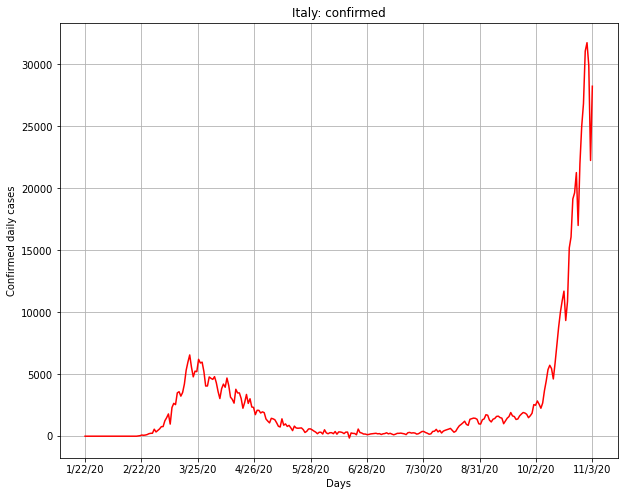

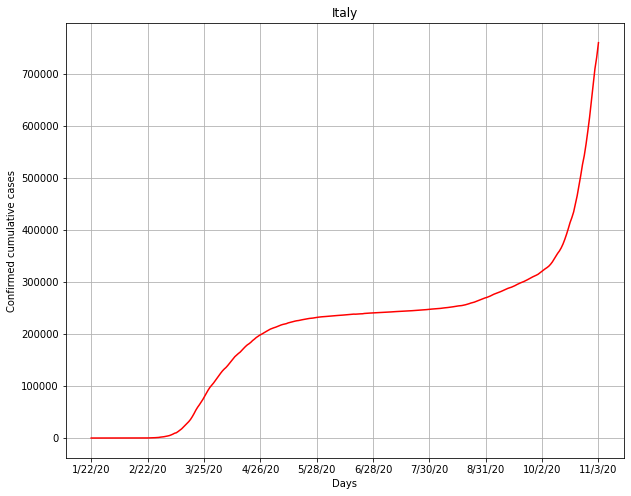

In [4]:
# Single country plots
COUNTRY = "Italy"
DATATYPE = "confirmed" # confirmed || recovered || deaths
 
data_cases = read_covid_data(DATATYPE)
if data_cases is None:
  print("Terminating...")
  exit(-1)
 
daily, cumulative, dates = extract_data(data_cases, country=COUNTRY)
 
if daily is None:
  print("Terminating...")
  exit(-1)
 
plot_simple(daily, dates, title=COUNTRY+": "+DATATYPE, numTicks=10, x_label="Days", y_label="Confirmed daily cases")
plot_simple(cumulative, dates, title=COUNTRY, numTicks=10, x_label="Days", y_label="Confirmed cumulative cases")

Code to generate a plot for multiple countries comparison.

Allows to pick:


*   confirmed / deaths /recovered
*   daily / cumulative
*   countries



Reading CONFIRMED CASES data
Reading DAILY data


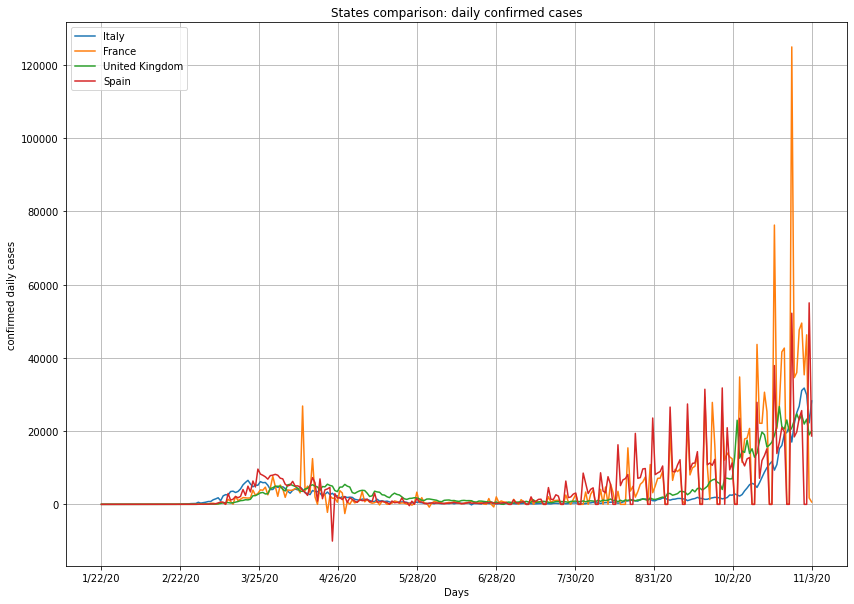

In [5]:
PLTTYPE = "daily" # daily || cumulative
DATATYPE = "confirmed" # confirmed || recovered || deaths
COUNTRIES = ""# UPDATE IT DOWN THERE
 
# Multiple countries plots
data = read_covid_data(filetype=DATATYPE)
if data is None:
  print("Terminating...")
  exit(-1)
 
COUNTRIES = get_countries(data, list_num=4) # 0: all countries | 1: EU countries | 2: medium list of countries | 3: small list of countries
 
whole = dict()
 
for c in COUNTRIES: 
  # daily, cumulative, dates = extract_data(data_cases, country=COUNTRY)
  lists = extract_data(data, country=c)
  whole[c] = lists
 
plot_complex(whole, plottype=PLTTYPE, title="States comparison: "+PLTTYPE+" "+DATATYPE+" cases", x_label="Days", y_label=DATATYPE+" daily cases", numTicks=10)

Code to generate a pie chart of the total (i.e. last day cumulative) confirmed / deaths /recovered cases.

Allows to pick:


*   confirmed / deaths /recovered
*   countries
*   minimum threshold to appear on the pie



Reading CONFIRMED CASES data


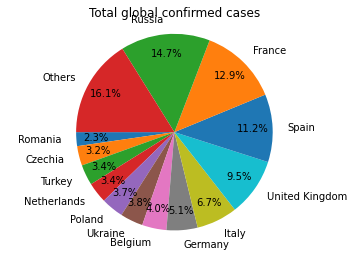

In [6]:
# Pie chart
DATATYPE = "confirmed" # confirmed || recovered || deaths
THRESHOLD = 0.02# *100 %
COUNTRIES = ""# UPDATE IT DOWN THERE
 
# Multiple countries plots
data = read_covid_data(filetype=DATATYPE)
if data is None:
  print("Terminating...")
  exit(-1)
 
#update these together to have a title consistent with the plot
COUNTRIES = get_countries(data, list_num=1) # 0: all countries | 1: EU countries
COUNTRIES_LABEL = "global" # global || european 
cntrs = (COUNTRIES, COUNTRIES_LABEL)
 
whole = dict()
 
for c in COUNTRIES: 
  # daily, cumulative, dates = extract_data(data_cases, country=COUNTRY)
  lists = extract_data(data, country=c)
  whole[c] = lists
 
plot_pie(whole, cntrs, THRESHOLD)

Barchart of cases / deaths / recovered % wrt State population

Reading CONFIRMED CASES data


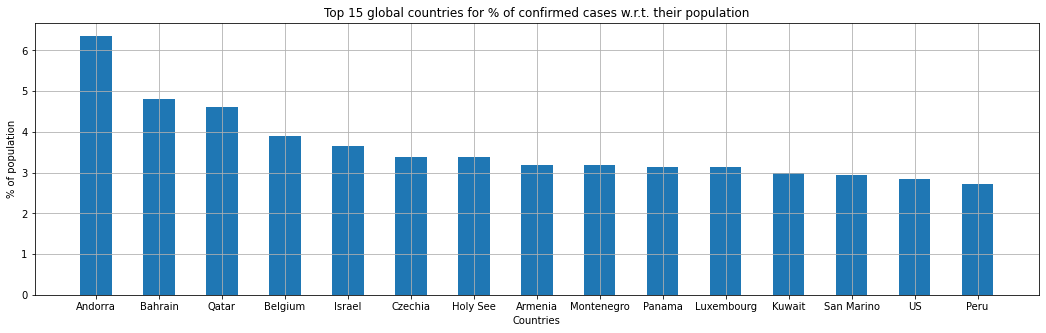

In [17]:
PLTTYPE = "cumulative" # daily || cumulative
DATATYPE = "confirmed" # confirmed || recovered || deaths
COUNTRIES = ""# UPDATE IT DOWN THERE
THRESHOLD = 15 # how many to be displayed

covid_data = read_covid_data(filetype=DATATYPE)
pop_data = read_population_data()
if pop_data is None or covid_data is None:
  print("Error: failed loading data")

COUNTRIES = get_countries(covid_data, list_num=0) # 0: all countries | 1: EU countries 
cntrs = (COUNTRIES, "global") # 0     global   || 1      european

COUNTRIES = cntrs[0]
LOC = cntrs[1]

not_present = ['Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Diamond Princess', 'Kosovo', 'MS Zaandam', 'West Bank and Gaza']
old_new = {"Côte d'Ivoire":"Cote d'Ivoire", "Czech Republic (Czechia)":"Czechia", "South Korea":"Korea, South", "Saint Kitts & Nevis":"Saint Kitts and Nevis", "St. Vincent & Grenadines":"Saint Vincent and the Grenadines", "Sao Tome & Principe":"Sao Tome and Principe", "Taiwan":"Taiwan*", "United States":"US"}
pop_data_new = pop_data.rename(index=old_new)

plot_barchart(covid_data, pop_data_new, COUNTRIES, not_present, THRESHOLD, "Top "+str(THRESHOLD)+" "+LOC+" countries for % of "+DATATYPE+" cases w.r.t. their population")


Pie Animation

In [ ]:
THRESHOLD = 0.015

covid_data = read_covid_data("confirmed")
_, _, dates = extract_data(covid_data, country="Italy")
TOT = len(dates)

COUNTRIES = get_countries(covid_data, list_num=0)

DESCR = "Evolution of COVID-19 confirmed cases distribution"



rc('animation', html='jshtml')

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, metadata=dict(artist='Matteo Garbarino'), bitrate=2400000)


shuffled_colors = list()
for c in matplotlib.colors.XKCD_COLORS:
  shuffled_colors.append(c)
random.shuffle(shuffled_colors)

whole = dict()
for countr, col in zip(COUNTRIES, shuffled_colors):
  _, cumulative, _ = extract_data(covid_data, country=countr)
  whole[countr] = (cumulative, col)


fig, ax = plt.subplots()


def update(day):
    ax.clear()
    ax.axis('equal')

    global whole
    global THRESHOLD
    global dates
    global DESCR

    cls = dict()
    for k, v in whole.items():
      cls[k] = v[1]

    tot = 0
    for v in whole.values():
      tot += (v[0])[day]

    percentages = dict()
    for k,v in whole.items():
      percentages[k]=(v[0])[day]/tot

    condensed = dict()
    for k,v in percentages.items():
      if v >= THRESHOLD:
        condensed[k]=v
      else:
        if "Others" in condensed:
          condensed["Others"] += v
        else:
          condensed["Others"] = v

    sorted_condensed = {k: v for k, v in sorted(condensed.items(), key=lambda item: item[1])}

    sorted_cls = list()
    for k in sorted_condensed.keys():
      if k == "Others":
        sorted_cls.append("tab:blue")
      else:
        sorted_cls.append(cls[k])
    

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = sorted_condensed.keys()
    sizes = sorted_condensed.values()

    ax.pie(sizes, labels=labels, colors=sorted_cls, autopct='%1.1f%%', shadow=True, startangle=140)
    
    ax.set_title(dates[day])

    ax.set_xlabel(DESCR)


anim = FuncAnimation(fig, update, frames=range(TOT), repeat=False, interval=250)
#plt.show()
anim.save('Animation.mp4', writer=writer)
anim


Barchart animation

In [ ]:
THRESHOLD = 20

PLTTYPE = "cumulative" # daily || cumulative
DATATYPE = "confirmed" # confirmed || recovered || deaths
covid_data = read_covid_data(filetype=DATATYPE)
pop_data = read_population_data()
_, _, dates = extract_data(covid_data, country="Italy")
TOT = len(dates)

COUNTRIES = get_countries(covid_data, list_num=0) # 0: all countries | 1: EU countries 
cntrs = (COUNTRIES, "global") # 0     global   || 1      european
COUNTRIES = cntrs[0]
LOC = cntrs[1]

DESCR = f"Evolution of the top {THRESHOLD} countries by % of population infected by COVID-19"

not_present = ['Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Diamond Princess', 'Kosovo', 'MS Zaandam', 'West Bank and Gaza']
old_new = {"Côte d'Ivoire":"Cote d'Ivoire", "Czech Republic (Czechia)":"Czechia", "South Korea":"Korea, South", "Saint Kitts & Nevis":"Saint Kitts and Nevis", "St. Vincent & Grenadines":"Saint Vincent and the Grenadines", "Sao Tome & Principe":"Sao Tome and Principe", "Taiwan":"Taiwan*", "United States":"US"}
pop_data_new = pop_data.rename(index=old_new)



rc('animation', html='jshtml')

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Matteo Garbarino'), bitrate=2400000)


shuffled_colors = list()
for c in matplotlib.colors.XKCD_COLORS:
  shuffled_colors.append(c)
random.shuffle(shuffled_colors)

whole = dict()
for countr, col in zip(COUNTRIES, shuffled_colors):
  _, cumulative, _ = extract_data(covid_data, country=countr)
  whole[countr] = (cumulative, col)

max_perc = list()
for k,v in whole.items():
  if k not in not_present:
    max_perc.append((v[0])[len(dates)-1]/pop_data_new.loc[k, "Population (2020)"])
highest_tick = max(max_perc)
y_ticks = list()
i = 0.0
while i <= highest_tick*100:
  y_ticks.append(i)
  i += 0.5
y_ticks.append(i)
#y_ticks = np.linspace(0, highest_tick, num=10)
#y_ticks *= 100
#print(y_ticks)

fig, ax = plt.subplots(figsize=(22,7))


def update(day):
    ax.clear()
    ax.axis('equal')

    global whole
    global THRESHOLD
    global dates
    global DESCR
    global pop_data_new
    global not_present
    global y_ticks

    cls = dict()
    for k, v in whole.items():
      cls[k] = v[1]

    percentages = dict()
    for k,v in whole.items():
      if k not in not_present:
        percentages[k]=(v[0])[day]/pop_data_new.loc[k, "Population (2020)"]

    sorted_percentages = {k: v for k, v in sorted(percentages.items(), key=lambda item: item[1], reverse=True)}

    limited_percentages = dict()

    cnt = 0
    for k,v in sorted_percentages.items():
      cnt += 1
      if cnt > THRESHOLD:
        break
      limited_percentages[k] = v*100

    x = limited_percentages.keys()
    height = limited_percentages.values()

    x_pos = [i for i, _ in enumerate(x)]

    sorted_cls = list()
    for k in limited_percentages.keys():
      if k == "Others":#not used here
        sorted_cls.append("tab:blue")
      else:
        sorted_cls.append(cls[k])

    bc = plt.bar(x_pos, height, color="tab:blue", width=0.5)
    for i in np.arange(len(height)):
      bc[i].set_color(sorted_cls[i])
    plt.xlabel("Countries")
    plt.ylabel("Percentage of infected population")

    xx = list()
    for el in x:
      if el == "United Arab Emirates":
        xx.append("Emirates")
      elif el == "Antigua and Barbuda":
        xx.append("Antigua,Barbuda")
      elif el == "United Kingdom":
        xx.append("UK")
      elif el == "Taiwan*":
        xx.append("Taiwan")
      else:
        xx.append(el)
    plt.xticks(x_pos, xx)
    plt.yticks(y_ticks)

    plt.grid(True)

    ax.set_title(dates[day])

    ax.set_xlabel(DESCR)


anim = FuncAnimation(fig, update, frames=range(TOT), repeat=False, interval=200)
#plt.show()
anim.save('Animation2.mp4', writer=writer)
anim

Fill plot

Reading CONFIRMED CASES data
Reading DEATHS data


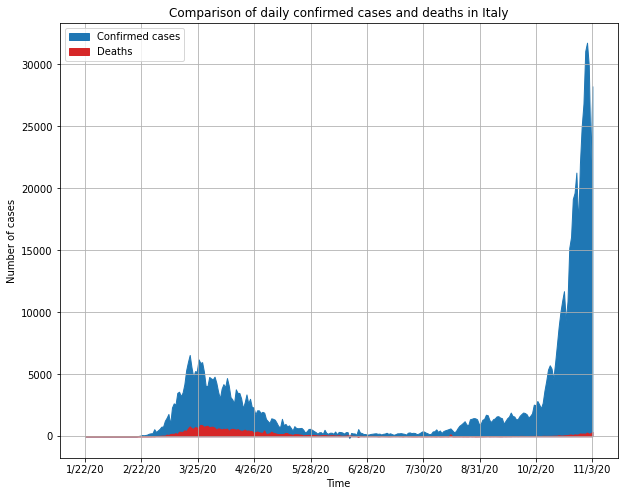

In [18]:
covid_data_confirmed = read_covid_data("confirmed")
covid_data_deaths = read_covid_data("deaths")
 
if covid_data_confirmed is None or covid_data_deaths is None:
  print("Error reading data")
  exit(-1)
 
daily_c, _, dates = extract_data(covid_data_confirmed, "Italy")
daily_d, _, dates = extract_data(covid_data_deaths, "Italy")
 
numTicks = 10
 
fig, ax = plt.subplots(figsize=(10,8))
ax.grid(True)
x = np.arange(len(dates))
ticks = np.linspace(0, len(dates)-1, numTicks)
lbl = list()
for t in ticks:
  lbl.append(dates[int(t)])
plt.xticks(ticks, lbl)
 
ax.fill_between(x, 0, daily_c, color="tab:blue", label="Confirmed cases")
ax.fill_between(x, 0, daily_d, color="tab:red", label="Deaths")
 
plt.title("Comparison of daily confirmed cases and deaths in Italy")
plt.xlabel("Time")
plt.ylabel("Number of cases")
ax.legend(loc='upper left')
 
plt.show()

7-days running average

Reading CONFIRMED CASES data
Reading DAILY data


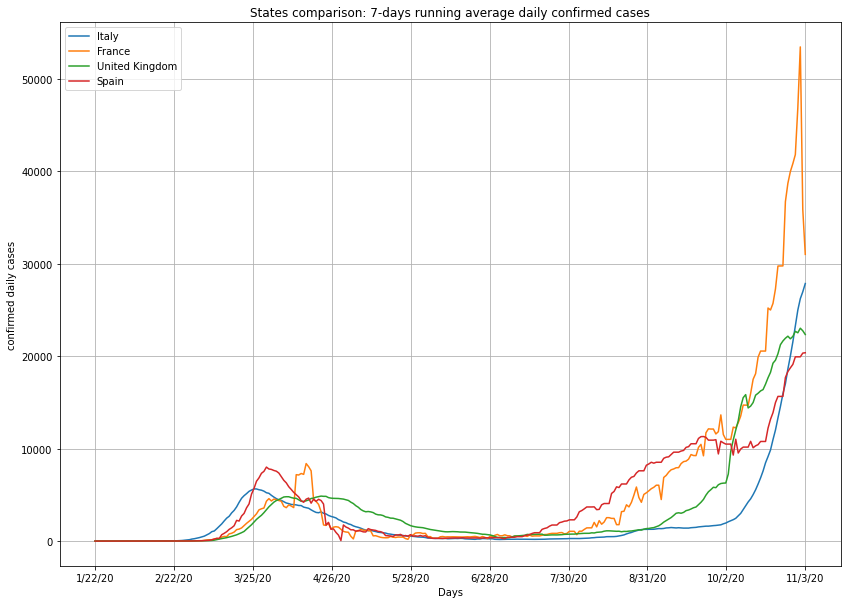

In [19]:
PLTTYPE = "daily" # daily || cumulative
DATATYPE = "confirmed" # confirmed || recovered || deaths
COUNTRIES = ""# UPDATE IT DOWN THERE
WINDOW = 7
 
# Multiple countries plots
data = read_covid_data(filetype=DATATYPE)
if data is None:
  print("Terminating...")
  exit(-1)
 
COUNTRIES = get_countries(data, list_num=4) # 0: all countries | 1: EU countries | 2: medium list of countries | 3: small list of countries
 
whole = dict()
 
for c in COUNTRIES: 
  # daily, cumulative, dates = extract_data(data_cases, country=COUNTRY)
  daily, cumulative, dates = extract_data(data, country=c)
  lists = get_running_average(daily, WINDOW), get_running_average(cumulative, WINDOW), dates
  whole[c] = lists
 
plot_complex(whole, plottype=PLTTYPE, title="States comparison: "+str(WINDOW)+"-days running average "+PLTTYPE+" "+DATATYPE+" cases", x_label="Days", y_label=DATATYPE+" daily cases", numTicks=10)